<a href="https://colab.research.google.com/github/dudeurv/SAM_MRI/blob/main/UNet_Model_BraTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Image Segmentation with U-NET


In [1]:
# Import libraries
import tarfile
import re
import imageio.v2 as iio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors
import scipy.ndimage
import textwrap

## Download the imaging dataset


In [2]:
!gdown https://drive.google.com/uc?id=1nHZWlCBpudbT4zzPyqyu2Vi5uILcxSrv

# Assuming the downloaded file is a ZIP file and its name is 'downloaded_data.zip'
import zipfile
with zipfile.ZipFile('Slices.zip', 'r') as zip_ref:
    zip_ref.extractall()


Downloading...
From: https://drive.google.com/uc?id=1nHZWlCBpudbT4zzPyqyu2Vi5uILcxSrv
To: /content/Slices.zip
100% 56.1M/56.1M [00:00<00:00, 227MB/s]


# Implement a dataset class

It can read the imaging dataset and get items, pairs of images and label maps, as training batches.

Train Sample: 1395 Test Sample: 310


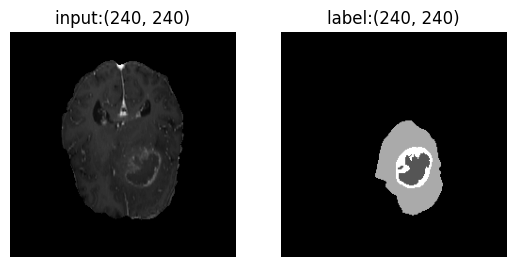

In [3]:
# Import necessary libraries
from torch.utils.data import Dataset, DataLoader  # PyTorch classes for handling datasets and data loading
from glob import glob                            # For file path pattern matching
import imageio.v2 as iio
import matplotlib.pyplot as plt
import numpy as np

def normalise_intensity(image, ROI_thres=0.1):
    pixel_thres = np.percentile(image, ROI_thres)
    ROI = np.where(image > pixel_thres, image, 0) # If image value is greater than pixel threshold, return image value, otherwise return 0
    mean = np.mean(ROI)
    std = np.std(ROI)
    ROI_norm = (ROI - mean) / (std + 1e-8) # Normalise ROI
    return ROI_norm

def map_labels(label):
    label_map = {0: 0, 85: 1, 170: 2, 255: 3}
    mapped_label = label.copy()
    for k, v in label_map.items():
        mapped_label[label == k] = v
    return mapped_label

# Define a custom dataset class for the Brats dataset
class BratsDataset(Dataset):
    # Initialization method of the class
    def __init__(self, root='brats_train'):
        # Get all image file paths using glob
        self.img_path_all = glob(root + '/BraTS-GLI-t1c/*.png')
        # Get the corresponding mask file paths by replacing 't1c' with 'seg' in the image paths
        self.mask_path_all = [img_path.replace('t1c', 'seg') for img_path in self.img_path_all]

    # Method to return the length of the dataset
    def __len__(self):
        return len(self.img_path_all)

    # Method to get an item from the dataset
    def __getitem__(self, index):
        # Read the image at the given index
        image = iio.imread(self.img_path_all[index])
        # Normalize the intensity of the image
        image = normalise_intensity(image)
        # Read the label (mask) corresponding to the image
        label = iio.imread(self.mask_path_all[index])
        # Map the label values to class indices
        label = map_labels(label)
        return image, label

# Create instances of the dataset for training and testing
train_dataset = BratsDataset(root='Slices/Train')
test_dataset = BratsDataset(root='Slices/Test')

# Print the number of samples in the training and testing datasets
print('Train Sample:', len(train_dataset), 'Test Sample:', len(test_dataset))

# Fetch a sample from the test dataset and visualize it
input, label = test_dataset[3]
plt.subplot(1,2,1), plt.axis('OFF'), plt.title('input:{}'.format(input.shape)), plt.imshow(input, cmap='gray')
plt.subplot(1,2,2), plt.axis('OFF'), plt.title('label:{}'.format(label.shape)), plt.imshow(label, cmap='gray');

# Build a U-net architecture

You will implement a U-net architecture. If you are not familiar with U-net, please read this paper:

[1] Olaf Ronneberger et al. [U-Net: Convolutional networks for biomedical image segmentation](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28). MICCAI, 2015.


In [4]:
class conv_block(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super().__init__()
    # Convolution layer, a ReLU activation to add non-linearity, and Batch Normalisation
    # Bias is set as false, as Batch Normalisation would remove the bias
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )
  def forward(self, x):
    return self.conv(x)

class UNet(nn.Module):
  # U-Net Model involves an encoder, a bottleneck and decoder section
  def __init__(self, num_classes=4):
    super().__init__()
    # Encoder with 4 blocks of Double_Convolution layers
    # Includes 4 sets of max pooling operations with kernel 2x2 and stride 2 for downsampling
    self.down_1 = nn.Sequential(
        conv_block(1, 16),
        conv_block(16, 16),
    )
    self.down_2 = nn.Sequential(
        conv_block(16, 32, 2),
        conv_block(32, 32),
    )
    self.down_3 = nn.Sequential(
        conv_block(32, 64, 2),
        conv_block(64, 64),
    )
    # Bottleneck
    # Includes a Double Convolution layer followed by upsampling with ConvTranspose2d
    self.bottle = nn.Sequential(
        conv_block(64, 128, 2),
        conv_block(128, 128),
        nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
    )

    # Decoder
    # Concatinating with skip connections causes feature channels to double
    # Double_Convolution and ConvTranspose2d each causes feature channels to halve
    self.up_1 = nn.Sequential(
        conv_block(128, 64),
        conv_block(64, 64),
        nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
    )
    self.up_2 = nn.Sequential(
        conv_block(64, 32),
        conv_block(32, 32),
        nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
    )
    # Final Output Layer
    self.out = nn.Sequential(
        conv_block(32, 16),
        conv_block(16, 16),
        nn.Conv2d(16, 4, kernel_size=1, padding=0)
    )

  def forward(self, x):
      # Use the convolutional operators defined above to build the U-net
      # Encoder
      x1 = self.down_1(x)
      x2 = self.down_2(x1)
      x3 = self.down_3(x2)

      x4 = self.bottle(x3)

      # Decoder
      ### Insert your code ###
      x5 = torch.cat((x4, x3), dim=1)
      x6 = self.up_1(x5)
      x7 = torch.cat((x6, x2), dim=1)
      x8 = self.up_2(x7)
      x9 = torch.cat((x8, x1), dim=1)
      x10 = self.out(x9)
      return x10


In [ ]:
# Import necessary libraries for the deep learning model
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader

# Define the training function for a single epoch
def train_per_epoch(model, trainloader, loss_fn, optimizer):
    model.train()  # Set the model to training mode (affects layers like dropout, batchnorm, etc.)
    loss_per_epoch = []  # Initialize a list to store loss values for each batch

    # Loop over each batch in the training loader
    for batch_idx, (images, labels) in enumerate(trainloader):
        # Move the images and labels to the defined device (GPU/CPU) and set appropriate data types
        images, labels = images.unsqueeze(1).to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)

        # Forward pass: compute the predicted labels by passing images to the model
        logits = model(images)

        optimizer.zero_grad()  # Zero out any existing gradients in the optimizer
        loss = loss_fn(logits, labels)  # Compute the loss between predictions and true labels
        loss.backward()  # Perform backpropagation to calculate gradients
        optimizer.step()  # Update the model parameters based on the gradients
        loss_per_epoch.append(loss.item())  # Append the current batch loss to the list

    # Calculate and return the average loss for the epoch
    return torch.tensor(loss_per_epoch).mean().item()

# Define the testing function for a single epoch
def test_per_epoch(model, testloader, loss_fn, optimizer):
    model.eval()  # Set the model to evaluation mode
    loss_per_epoch = []  # Initialize a list to store loss values for each batch

    # Disable gradient calculations for efficiency during testing
    with torch.no_grad():
        # Loop over each batch in the testing loader
        for batch_idx, (images, labels) in enumerate(testloader):
            # Move the images and labels to the defined device and set appropriate data types
            images, labels = images.unsqueeze(1).to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)

            # Forward pass: compute the predicted labels by passing images to the model
            logits = model(images)

            # Compute the loss and append to the list
            loss = loss_fn(logits, labels)
            loss_per_epoch.append(loss.item())

    # Calculate and return the average loss for the epoch
    return torch.tensor(loss_per_epoch).mean().item()

# Determine if a CUDA GPU is available for training, otherwise use the CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define key model parameters
num_classes = 4  # Number of classes for segmentation
model = UNet(num_classes=num_classes)  # Initialize the U-Net model with the number of classes
model = model.to(device)  # Move the model to the defined device

# Define key training parameters
epochs = 120  # Total number of training epochs
train_batch_size = 25  # Batch size for training
eval_batch_size = 300  # Batch size for evaluation/testing

# Create instances of the dataset for training and testing
train_dataset = BratsDataset(root='Slices/Train')
test_dataset = BratsDataset(root='Slices/Test')

# Define a directory to save model states
model_dir = 'saved_models'
os.makedirs(model_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Define the optimizer and loss function for training
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Optimizer (Adam) with a learning rate of 0.001
loss_fn = nn.CrossEntropyLoss(ignore_index=128)  # Loss function (Cross-Entropy Loss)

# Create data loaders for training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=eval_batch_size, shuffle=False, num_workers=2)

# Print basic information about the training setup
print('Training on:', device, 'train sample size:', len(train_dataset), 'test sample size:', len(test_dataset))

# Initialize variables to track the best model performance
best_epoch, best_loss = 0.0, np.inf

# Training loop for the specified number of epochs
for epoch in range(epochs):
    # Perform training and testing for the current epoch
    loss_training = train_per_epoch(model, train_loader, loss_fn, optimizer)
    loss_testing = test_per_epoch(model, test_loader, loss_fn, optimizer)

    # Check if the current model's performance is the best so far
    if loss_testing < best_loss:
        best_loss = loss_testing  # Update the best loss
        best_epoch = epoch  # Update the best epoch
        # Save the model state
        torch.save(model.state_dict(), os.path.join(model_dir, 'model_best.pt'))

    # Print the training and testing loss for the current epoch
    print(f'--- Epoch {epoch}/{epochs}: Training loss = {loss_training:.4f}, Testing loss = {loss_testing:.4f}, Best loss = {best_loss:.4f}, Best epoch = {best_epoch} ')

Training on: cuda train sample size: 1395 test sample size: 310
--- Epoch 0/120: Training loss = 0.7602, Testing loss = 0.5250, Best loss = 0.5250, Best epoch = 0 
--- Epoch 1/120: Training loss = 0.3639, Testing loss = 0.2726, Best loss = 0.2726, Best epoch = 1 
--- Epoch 2/120: Training loss = 0.1905, Testing loss = 0.1637, Best loss = 0.1637, Best epoch = 2 
--- Epoch 3/120: Training loss = 0.1161, Testing loss = 0.1139, Best loss = 0.1139, Best epoch = 3 
--- Epoch 4/120: Training loss = 0.0841, Testing loss = 0.0986, Best loss = 0.0986, Best epoch = 4 
--- Epoch 5/120: Training loss = 0.0673, Testing loss = 0.0865, Best loss = 0.0865, Best epoch = 5 
--- Epoch 6/120: Training loss = 0.0569, Testing loss = 0.0827, Best loss = 0.0827, Best epoch = 6 
--- Epoch 7/120: Training loss = 0.0485, Testing loss = 0.0710, Best loss = 0.0710, Best epoch = 7 
--- Epoch 8/120: Training loss = 0.0427, Testing loss = 0.0746, Best loss = 0.0710, Best epoch = 7 


Evaluation:

In [8]:
pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 9.6 MB/s eta 0:00:00


Test Sample: 310


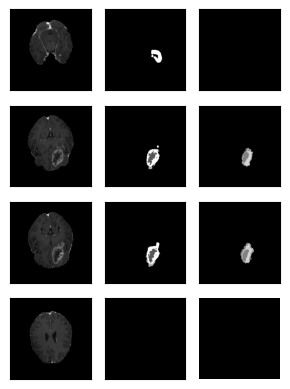

Class Wise Dice: {'dice_cls:1': 0.42232, 'dice_cls:2': 0.2659420840617162, 'dice_cls:3': 0.6863996705446309}
Overall Dice: 0.45822058486878237


In [9]:
# Import necessary libraries for metrics and visualization
from torchmetrics import Dice
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F

# Define a function to calculate the confusion matrix from predictions and ground truths
def calculate_confusion_matrix_from_arrays(prediction, ground_truth, nr_labels):
    # Stack the ground truth and prediction arrays and transpose
    replace_indices = np.vstack((
        ground_truth.flatten(),
        prediction.flatten())
    ).T
    # Compute the confusion matrix using histogram
    confusion_matrix, _ = np.histogramdd(
        replace_indices,
        bins=(nr_labels, nr_labels),  # Number of bins for each dimension (nr_labels)
        range=[(0, nr_labels), (0, nr_labels)]  # Range of labels
    )
    # Convert the confusion matrix to uint32 for consistency
    confusion_matrix = confusion_matrix.astype(np.uint32)
    return confusion_matrix

# Define a function to calculate the Dice coefficient from the confusion matrix
def calculate_dice(confusion_matrix):
    dices = []  # Initialize a list to store Dice scores for each class
    # Iterate over each class to calculate Dice score
    for index in range(confusion_matrix.shape[0]):
        true_positives = confusion_matrix[index, index]  # Diagonal elements are true positives
        false_positives = confusion_matrix[:, index].sum() - true_positives
        false_negatives = confusion_matrix[index, :].sum() - true_positives
        denom = 2 * true_positives + false_positives + false_negatives
        # Handle the case where denominator is zero
        if denom == 0:
            dice = 0
        else:
            dice = 2 * float(true_positives) / denom
        dices.append(dice)  # Append the Dice score for the current class
    return dices

# Define a function to test the model for an epoch and visualize the results
def test_per_epoch(model, testloader):
    model.eval()  # Set the model to evaluation mode
    # Setup the plot for visualization
    fig, axs = plt.subplots(len(testloader), 3, figsize=(1*3, len(testloader)*1), subplot_kw=dict(xticks=[],yticks=[]))
    # Initialize an empty confusion matrix
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.uint32)

    with torch.no_grad():
        # Iterate over the testloader
        for batch_idx, (images, labels) in enumerate(testloader):
            # Prepare images and labels for model input
            images, labels = images.unsqueeze(1).to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
            # Forward pass through the model to get logits
            logits = model(images)
            # Apply softmax to get probabilities and then get the predicted segmentation
            prob = F.softmax(logits, dim=1)
            pred_seg = torch.argmax(prob, dim=1)
            # Update the confusion matrix with predictions
            confusion_matrix += calculate_confusion_matrix_from_arrays(pred_seg.cpu(), labels.cpu(), num_classes)
            # Visualize the input image, ground truth, and prediction
            img_num = 0
            axs[batch_idx, 0].imshow(images[img_num, 0].cpu().numpy(), cmap='gray')
            axs[batch_idx, 1].imshow(labels[img_num].cpu().numpy(), cmap='gray')
            axs[batch_idx, 2].imshow(pred_seg[img_num].cpu().numpy(), cmap='gray')

    # Exclude the background from the confusion matrix for Dice calculation
    confusion_matrix = confusion_matrix[1:, 1:]
    # Calculate Dice scores per class
    dices_per_class = {'dice_cls:{}'.format(cls + 1): dice
                for cls, dice in enumerate(calculate_dice(confusion_matrix))}

    # Adjust plot layout and display
    plt.axis('OFF')
    plt.tight_layout()
    plt.show()
    return dices_per_class

# Set the number of classes for segmentation
num_classes = 4
# Initialize the U-Net model and load the best saved weights
model = UNet(num_classes=num_classes).to(device)
model.load_state_dict(torch.load('/content/saved_models/model_best.pt'))

# Define evaluation batch size and create a DataLoader for the test set
eval_batch_size = 80
print('Test Sample:', len(test_dataset))
test_loader = DataLoader(test_dataset, batch_size=eval_batch_size, shuffle=False, num_workers=2)

# Perform testing and calculate class-wise and overall Dice scores
dices_per_class = test_per_epoch(model, test_loader)
dices_per_class_list = np.array(list(dices_per_class.values()))
print('Class Wise Dice:', dices_per_class)
print('Overall Dice:', np.mean(dices_per_class_list))